# 2. Train autoencoder

## 2.1 Set environment
For building the neural network, Keras is used as an interface to TensorFlow. The location of the data file is set in the file variable.

In [22]:
import numpy as np
import keras
from keras import layers
from keras.models import save_model, load_model
from keras.callbacks import TensorBoard
from isoplot import isoplot
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Set location of data file
file="data/data.npy"

## 2.2 Create train, validate and test datasets
After randomizing the order of the data, the dataset is split in 3 parts:
- a train dataset for training the NN with 90% of the data
- a validation dataset, used to validate the model during training, with 5% of the data
- a test dataset, which is not used during training, to evaluate the model, with 5% of the data

In [2]:
# N is the size of the test and validation dataset
N = 2000
data = np.load(file)
i = np.argsort(np.random.random(data.shape[0]))
data = data[i]
test = data[:N//2]
validate = data[N//2:N]
train = data[N:]

## 2.3 Architecture of the neural network
Convolute...

In [3]:
# Encoder (32,64,2) - > (4,8,1)
input = keras.Input(shape=(32, 64, 2))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)

# Decoder (4,8,1) -> (32,64,2)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='MSE')
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 64, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 64, 32)        608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 16, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 16, 8)          1160  

2022-06-09 12:51:02.558682: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## 2.4 Train the model
train...

In [4]:
autoencoder.fit(train, train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(validate, validate),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

autoencoder.save("data/model2.h5")
#save_model(autoencoder,"model2")
#autoencoder.save_weights("data/weights2.h5")

Epoch 1/50
151/151 [==============================] - 48s 316ms/step - loss: 0.0098 - val_loss: 0.0039
Epoch 2/50
151/151 [==============================] - 50s 332ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 3/50
151/151 [==============================] - 49s 324ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 4/50
151/151 [==============================] - 50s 334ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/50
151/151 [==============================] - 49s 323ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/50
151/151 [==============================] - 49s 323ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/50
151/151 [==============================] - 51s 337ms/step - loss: 0.0010 - val_loss: 9.9293e-04
Epoch 8/50
151/151 [==============================] - 49s 325ms/step - loss: 9.8555e-04 - val_loss: 9.4621e-04
Epoch 9/50
151/151 [==============================] - 51s 335ms/step - loss: 9.3448e-04 - val_loss: 9.3659e-04
Epoch 10/50
151/151 [==============================] 

## 2.5 Start tensorboard
Train...

In [13]:
%%bash
tensorboard --host 0.0.0.0 --logdir=/tmp/autoencoder 2> /dev/null &
#firefox 127.0.0.1:6006 &

Process is interrupted.


## 2.6 Evaluate the model

In [6]:
score = autoencoder.evaluate(test, test, verbose=0)
print('Test loss:', score)

Test loss: 0.000786717573646456


## 2.7 Compare the isoplots 

(32, 64)


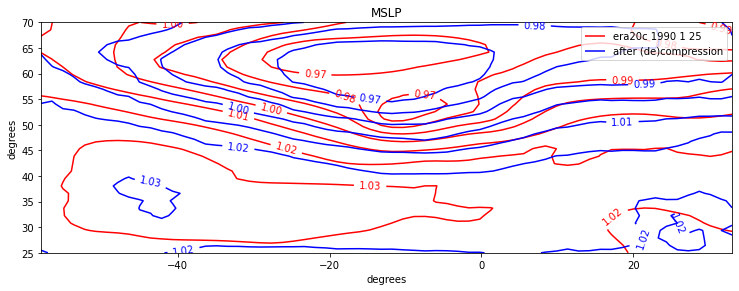

In [42]:
#date = "1976 8 1"
#date = "2000 1 1"
date = "1990 1 25"

autoencoder = load_model("data/autoencoder.h5")
x = np.load(file)
dates = np.load("data/dates.npy")
zone = np.load("data/zone.npy")
scale = np.load("data/scale.npy")
date_index = np.where(dates == date)
x_in = data[date_index]
print(x_in[0,:,:,0].shape)

# predict 
x_predict = autoencoder.predict(x_in) 

# plot
isoplot(x_in[0,:,:,0],x_predict[0,:,:,0],"era20c "+date,"after (de)compression",zone,scale[0],scale[0])

(32, 64)


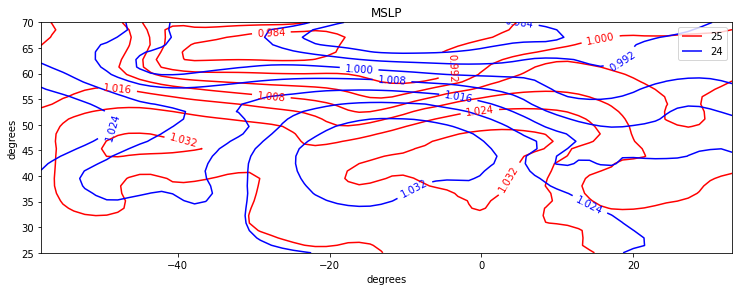

In [40]:
x0=x[24,:,:,0]
print(x0.shape)
x1=x[25,:,:,0]
isoplot(x1,x0,"25","24",zone,scale[0],scale[0])